# fanCE Tutorial

$\texttt{fanCE}$ (pronounced "fan-SEE-EE" for flexible analytic Chemical Evolution) is a one-zone chemical evolution code that implements the [Weinberg, Andrews, & Freudenburg (2017)](https://iopscience.iop.org/article/10.3847/1538-4357/837/2/183)  analytic solution for a flexible, two-parameter star formation history.

In this tutorial, we will use $\texttt{fanCE}$ to generate the star formation history, time evolution of [Mg/H], [Fe/H], and [Mg/Fe], and evolution of mean stellar <br> $\langle$age$\rangle$, $\langle$[Mg/H]$\rangle$, and $\langle$[Mg/Fe]$\rangle$ for the reference model in Gountanis et al. 2024. We will also show how to modify the $\texttt{fanCE}$ defualt parameters to explore alternative assumptions and interpret other galaxies or stellar populations.

Let's begin by importing a few modules we will need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fance.models import waf2017, fance
from fance.par import DefaultfanCEParSet
from fance.plotting import plotSFH, plotGas, plotStellar
from fance.utils import weight_stellar_props

## fanCE Parameters

The table below defines the $\texttt{fanCE}$ parameters and shows their corresponding defualt values. Parameters with default values listed as <code>None</code> are computed in $\texttt{fanCE}$ using <code>aFeEq</code> and <code>mu</code> if set to <code>None</code>. <code>IaDTD_fn</code> is the functional form of the SN Ia DTD and can either be a <code>'powerlaw'</code> with a slope of -1.1 or an <code>'exponential'</code> with an e-folding time set by <code>tauIa</code>. Additional information about the parameters can be found in <code>models.py</code> and <code>par.py</code> and in Gountanis et al. 2024. 

| Parameter | Definition | Default Value |
| :---: | :---: | :---: |
| t_start | star formation start time | 0.5 [Gyr] |
| t_0 | age of Universe at observed redshift | 14 [Gyr] |
| dt | time step | 0.02 [Gyr] |
| tauSFE | star formation efficiency timescale | 1.0 [Gyr] |
| tauSFH1 | star formation history rise timescale | 2.0 [Gyr] |
| tauSFH2 | star formation history  decline timescale | 8.0 [Gyr] |
| aFeCC | [Mg/Fe] plateau from the CCSN yield ratio | 0.45 |
| aFeEq | [Mg/Fe] late-time equilibrium ratio | 0 |
| mu | constant used to determine the Type Ia Fe yield | 1.1 |
| yOCC | IMF-averaged CCSN O yield | None |
| yMgCC | IMF-averaged CCSN Mg yield | None |
| yFeCC | IMF-averaged CCSN Fe yield | None |
| yFeIa | IMF-averaged SNIa Fe yield | None |
| fRetCC | fraction of metals returned to the ISM by CCSNe | 1.0 |
| r | mass recycling parameter | 0.4 |
| eta | =$\dot{M}_{out}/\dot{M}_{\star}$, mass loading factor | 0.3 |
| tauIa | e-folding time for SNIa DTD | 0 [Gyr] |
| SolarO | Solar O mass fraction | 0.00733 |
| SolarMg | Solar Mg mass fraction | 0.000671 |
| SolarFe | Solar Fe mass fraction | 0.00137 |
| IaDTD_fn | functional form of the SN Ia DTD | 'powerlaw' |

## Star Formation History and Gas Abundance Evolution

$\texttt{fanCE}$ implements a two-parameter star formation history $\propto(1-e^{-t/\tau_1})\cdot e^{-t/\tau_2}$, which rises linearly on a timescale $\tau_1$ and then falls exponentially on a timescale $\tau_2$ for $\tau_1>\tau_2>0$.

We will generate the star formation history and time evolutions of [O/H], [Mg/H], [Fe/H], [O/Fe], and [Mg/Fe] using the function <code>fance()</code>. Let's begin by setting our parameters equal to the $\texttt{fanCE}$ default parameters: 

In [4]:
# load fanCE default parameters
par = DefaultfanCEParSet()

# print parameters
print(par)

{'t_start': 0.5, 't0': 14.0, 'dt': 0.02, 'tauSFE': 1.0, 'tauSFH1': 2.0, 'tauSFH2': 8.0, 'aFeCC': 0.45, 'aFeEq': 0.0, 'mu': 1.1, 'yOCC': None, 'yMgCC': None, 'yFeCC': None, 'yFeIa': None, 'fRetCC': 1.0, 'r': 0.4, 'eta': 0.3, 'tauIa': 0, 'tDminIa': 0.15, 'SolarO': 0.00733, 'SolarMg': 0.000671, 'SolarFe': 0.00137, 'IaDTD_fn': 'powerlaw'}


In [3]:
# Call fance
t, sfr, OH, MgH, FeH, OFe, MgFe = fance(**par)

We can plot the star formation history using <span style="background-color: #F2F2F2">plotSFH( )</span>. Here, the star formation history is normalized to give the galaxy's stellar mass formed per Gyr:

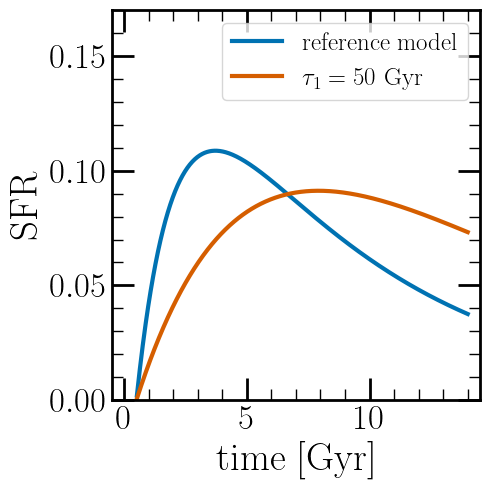

In [4]:
ax = plotSFH(t, sfr, labels="reference model", c='C0')


# update tau1, run fance, and add results to the plot
par['tauSFH1'] = 50
t, sfr1, OH1, MgH1, FeH1, OFe1, MgFe1 = fance(**par)
ax = plotSFH(t, sfr1, labels="$\\tau_1=50$ Gyr", ax = ax, c='C2')

We can plot [Mg/H], [Fe/H], and [Mg/Fe] versus time using <span style="background-color: #F2F2F2">plotGas( )</span>. [O/H] and [O/Fe] are not included in <span style="background-color: #F2F2F2">plotGas( )</span> since they have identical evolution tracks to [Mg/H] and [Mg/Fe], respectively.

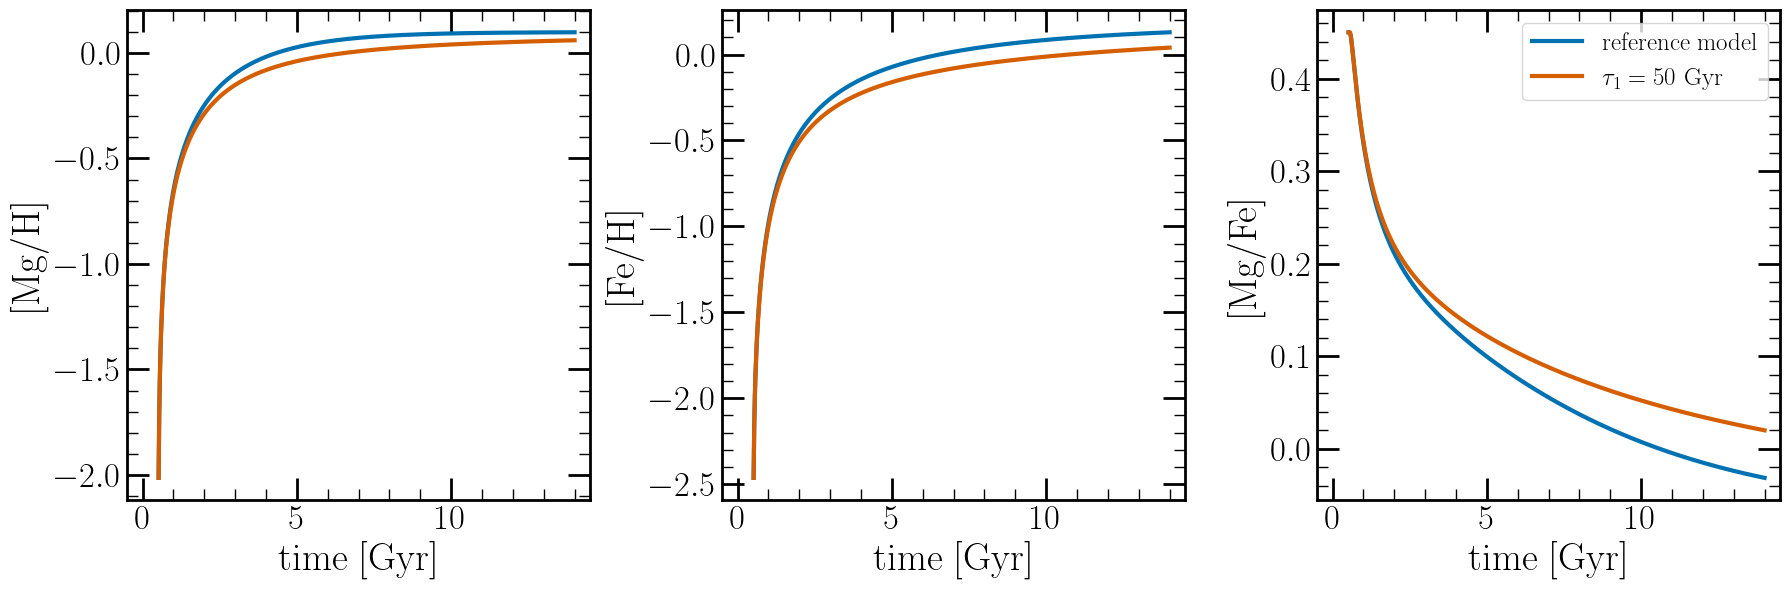

In [5]:
ax = plotGas(t, MgH, FeH, MgFe, labels="reference model", c='C0')
ax = plotGas(t, MgH1, FeH1, MgFe1, labels="$\\tau_1=50$ Gyr", ax = ax, c='C2')

## Mean Age and Stellar Abundance Evolution

Now we will use the star formation history and gas abundances generated by <span style="background-color: #F2F2F2">fance( )</span> to determine the light-weighted, log-averaged stellar age and abundances.

Let's start by computing the light-weighting function using <span style="background-color: #F2F2F2">weight( )</span>. Setting <span style="background-color: #F2F2F2">$t_0=0$</span> returns <span style="background-color: #F2F2F2">lightweight=1</span>, corresponding to mass-weighting.

The function <span style="background-color: #F2F2F2">stellar( )</span> returns $\langle$age$\rangle$, $\langle$[O/H]$\rangle$, $\langle$[Mg/H]$\rangle$, $\langle$[Fe/H]$\rangle$, $\langle$[O/Fe]$\rangle$, $\langle$[Mg/Fe]$\rangle$:

In [6]:
par["tauSFH1"] = 2
mean_age, OHStar, MgHStar, FeHStar, OFeStar, MgFeStar = weight_stellar_props(t, par["t0"], sfr, OH, MgH, FeH, light_weighted=True)

par["tauSFH1"] = 50
mean_age1, OHStar1, MgHStar1, FeHStar1, OFeStar1, MgFeStar1 = weight_stellar_props(t, par["t0"], sfr, OH, MgH, FeH, light_weighted=True)

We can plot $\langle$age$\rangle$, [Mg/H], $\langle$[Mg/H]$\rangle$, [Mg/Fe], and $\langle$[Mg/Fe]$\rangle$ versus time as well as $\langle$[Mg/H]$\rangle$ and $\langle$[Mg/Fe]$\rangle$ versus $\langle$age$\rangle$ using <span style="background-color: #F2F2F2">plotStellar( )</span>. [O/H], $\langle$[O/H]$\rangle$, [O/Fe], and $\langle$[O/Fe]$\rangle$ are not included in <span style="background-color: #F2F2F2">plotStellar( )</span> since they have identical evolution tracks to [Mg/H], $\langle$[Mg/H]$\rangle$, [Mg/Fe], and $\langle$[Mg/Fe]$\rangle$, respectively.

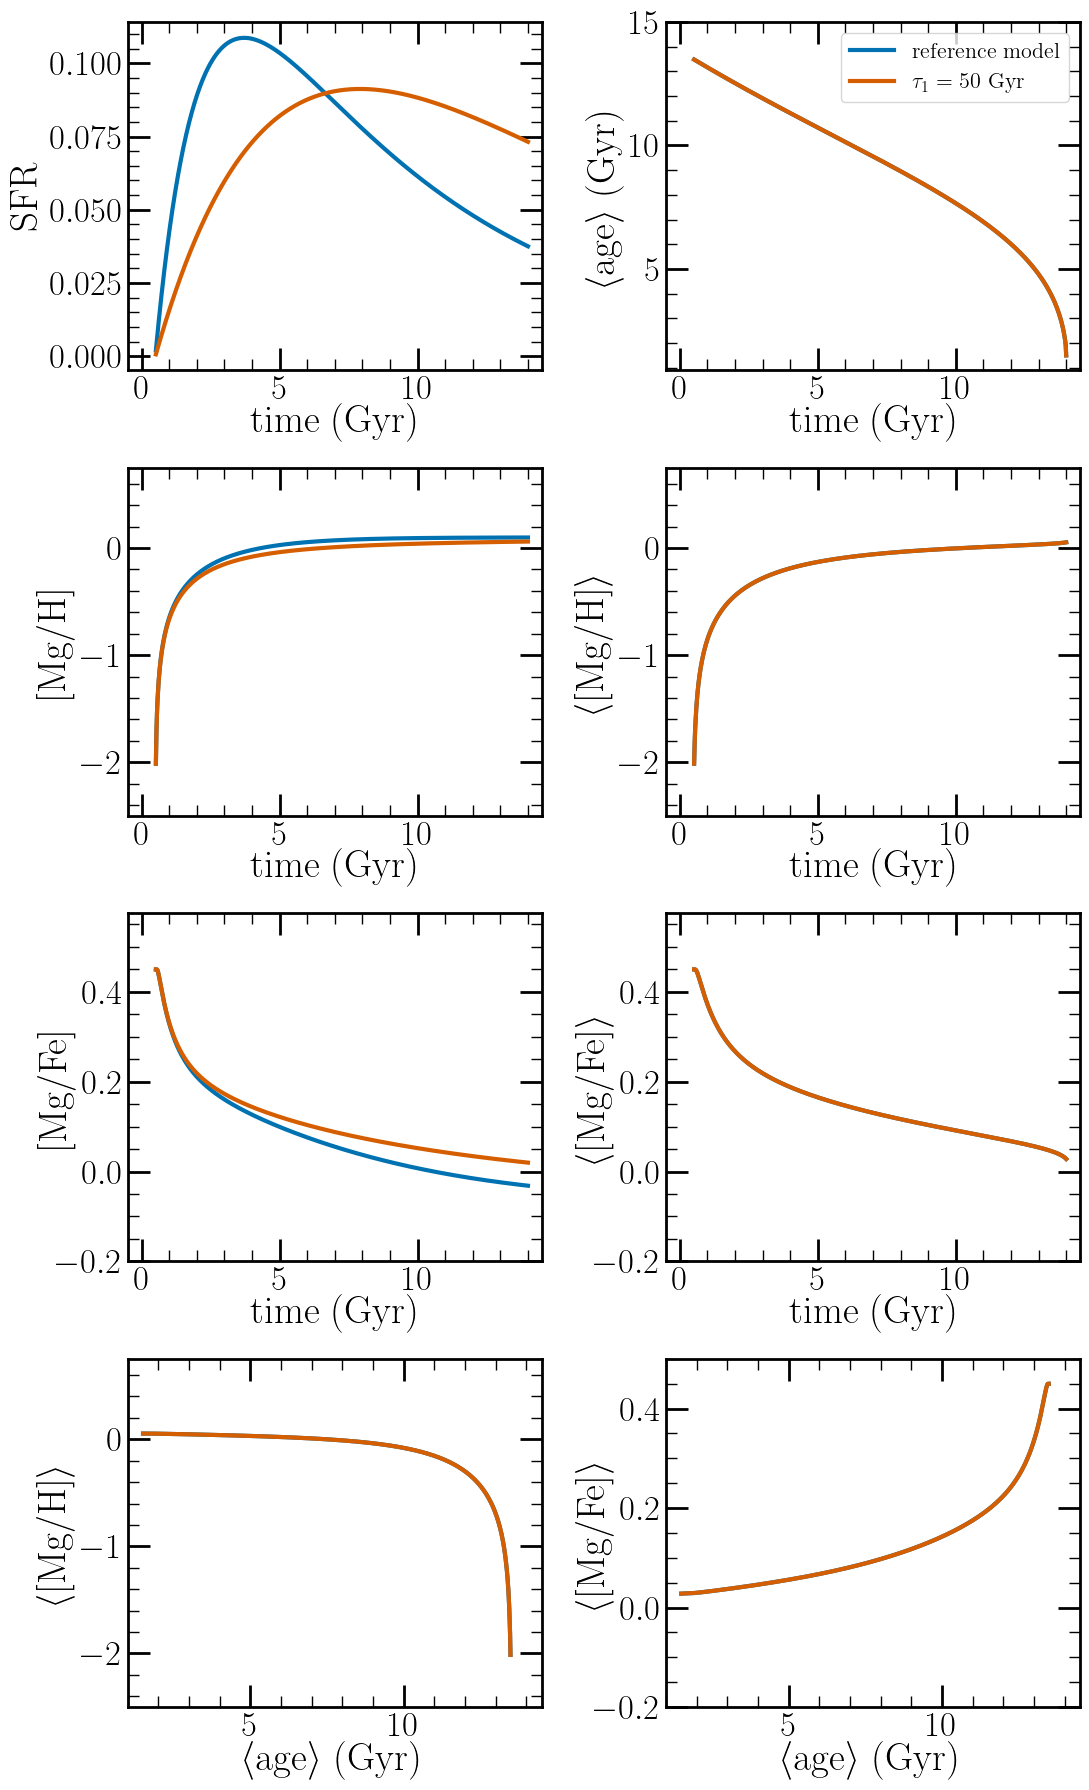

In [7]:
ax = plotStellar(t, sfr, mean_age, MgH, MgFe, MgHStar, MgFeStar, labels="reference model",c='C0')
ax = plotStellar(t, sfr1, mean_age1, MgH1, MgFe1, MgHStar1, MgFeStar1, labels="$\\tau_1=50$ Gyr", ax=ax, c='C2')